## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#list(STOP_WORDS)[0:100]

In [3]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(n=5000, random_state=42)
#congress_tweets.head()

In [4]:
rep_count = (congress_tweets['position']=='Rep').sum()
sen_count = (congress_tweets['position']=='Sen').sum()
rep_count, sen_count

(3788, 1212)

In [5]:
cons_count = (congress_tweets['party']=='Republican').sum() 
lib_count = (congress_tweets['party']=='Democrat').sum()

cons_count, lib_count

(1705, 3261)

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [6]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]

    #new filtering of RT
    spacy_words = [word for word in spacy_words if word.lower() not in ['rt', 'amp']]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc


## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

In [7]:
# apply rem_punc_stop function and tokenize 'text' column

congress_tweets['tokens'] = congress_tweets['text'].dropna().apply(rem_punc_stop)
#congress_tweets['tokens'] #visualize
#congress_tweets.head()

#flatens lists of lists: create a single list by iterating over each list of tokens in the 'token' col and then iterates over each token w/i those lists
all_words = [word for tweet in congress_tweets['tokens'] for word in tweet if word.isalnum()] #what to do about emojis?
#print(all_words)

#word frequency 
from collections import Counter
word_count = Counter(all_words)
most_common_words = word_count.most_common(20)
most_common_words


[('I', 1775),
 ('The', 825),
 ('QT', 707),
 ('We', 631),
 ('This', 462),
 ('Trump', 457),
 ('people', 405),
 ('help', 393),
 ('need', 372),
 ('House', 368),
 ('COVID19', 367),
 ('President', 357),
 ('today', 352),
 ('health', 349),
 ('Act', 345),
 ('work', 336),
 ('American', 335),
 ('It', 333),
 ('Congress', 312),
 ('Americans', 305)]

/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


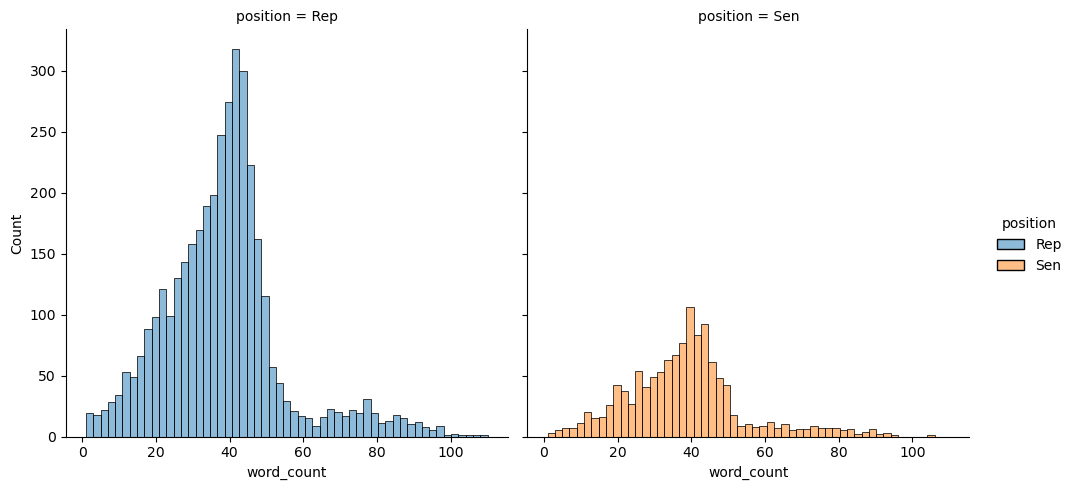

In [8]:
# word count
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x:len(str(x).split()))

#plot 
sns.displot(congress_tweets,
            x='word_count',
           hue = 'position',
           col = 'position')
plt.show()

/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


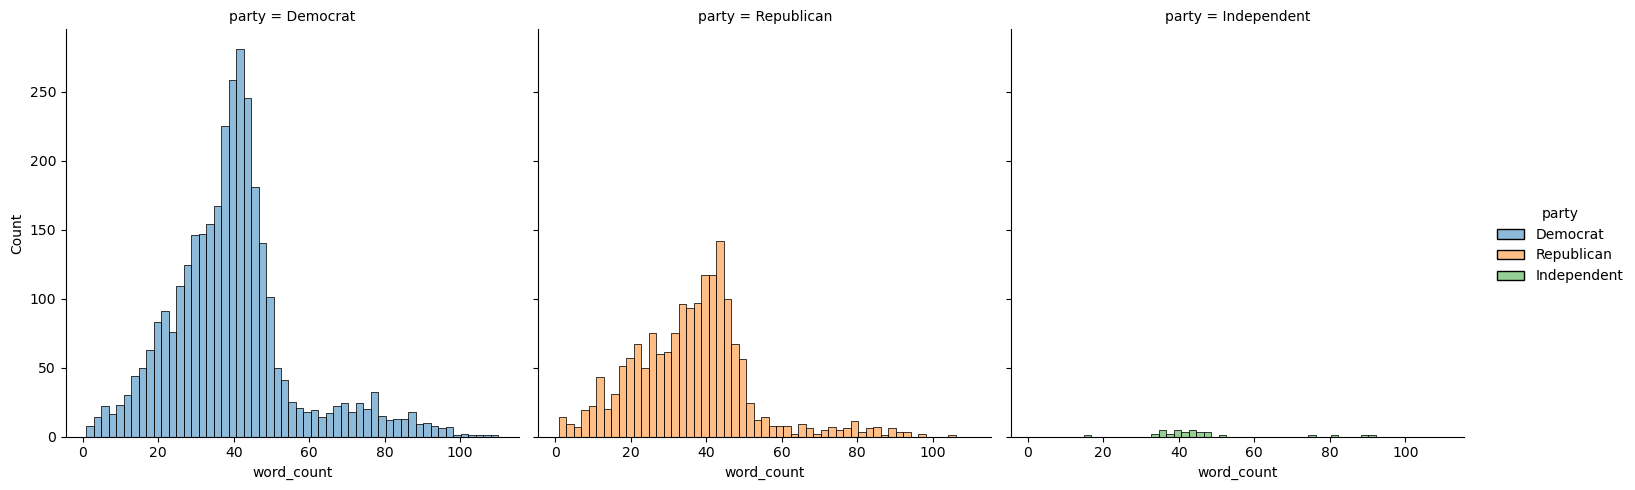

In [9]:
#plot 
sns.displot(congress_tweets,
            x='word_count',
           hue = 'party',
           col = 'party')
plt.show()

### EDA 2

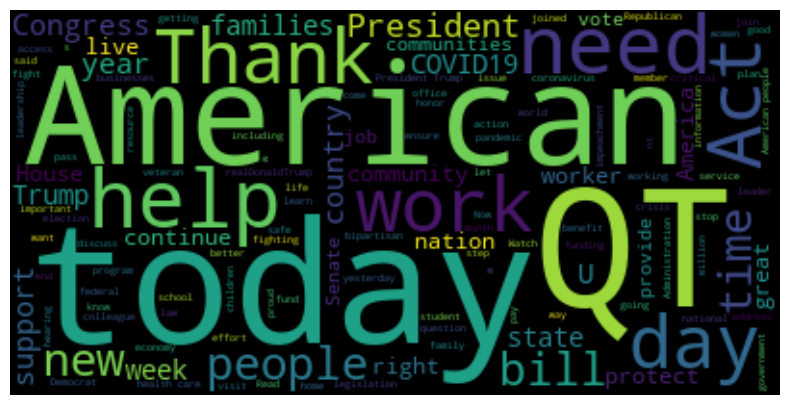

In [10]:
#import word cloud
from wordcloud import WordCloud
    
#generate word cloud
wordcloud_txt = ' '.join(all_words)
wordcloud = WordCloud(background_color = 'black').generate(wordcloud_txt)

#display word cloud
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
                                       

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [11]:
congress_tweets['tokens'] = congress_tweets['tokens'].dropna().apply(lambda text: ' '.join(text))


#create polarity col
congress_tweets['polarity'] = congress_tweets['tokens'].apply(lambda text: TextBlob(text).sentiment.polarity)

#display
#congress_tweets.head()

/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


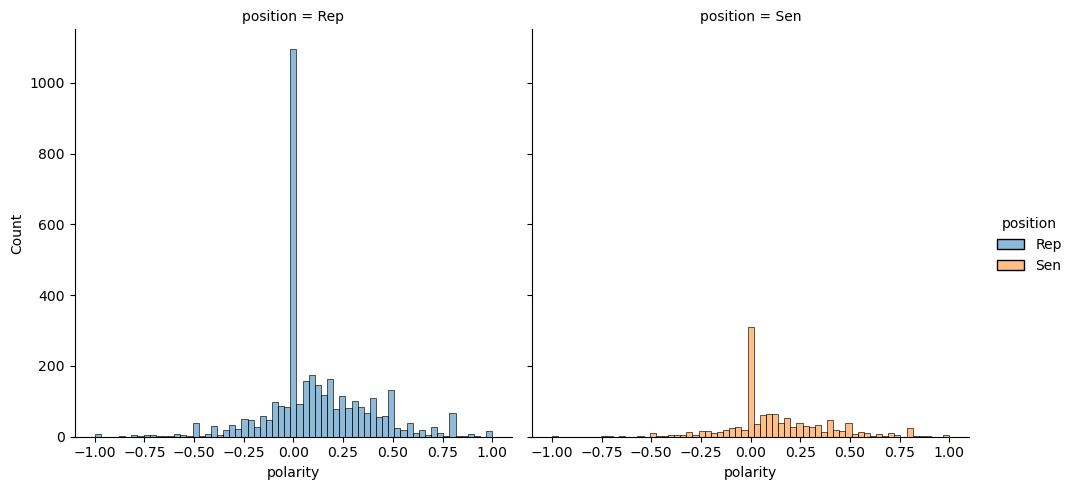

In [12]:
sns.displot(congress_tweets,
            x='polarity',
           hue = 'position',
           col = 'position')

plt.show()

/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


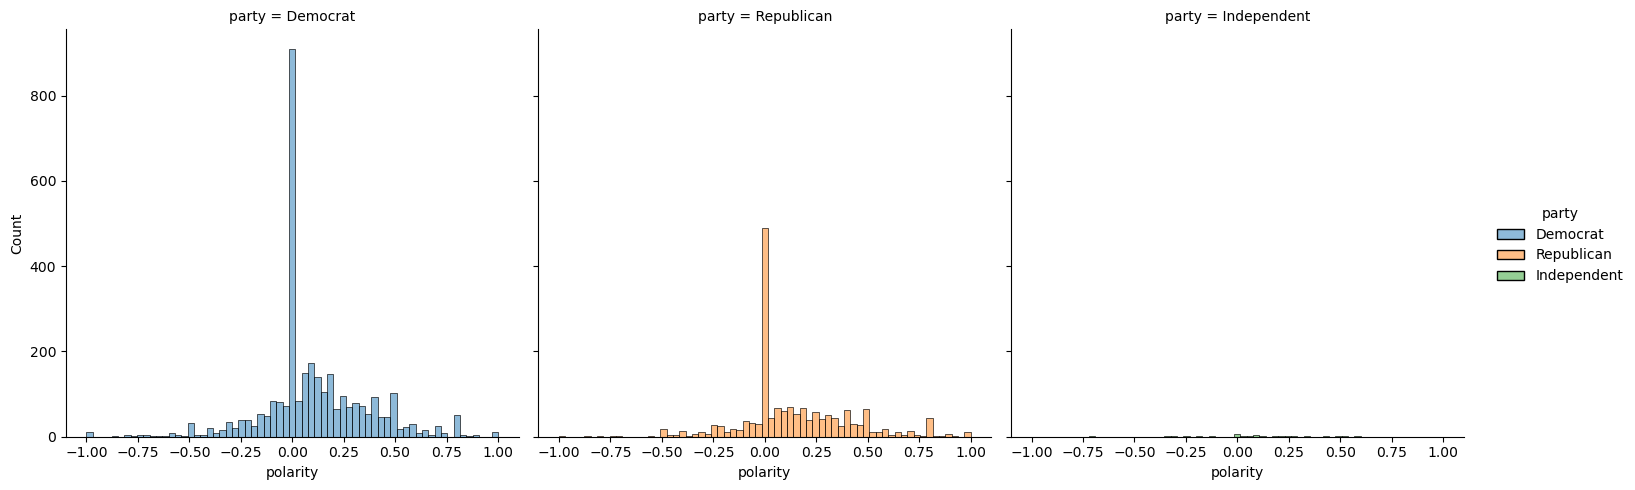

In [13]:
sns.displot(congress_tweets,
            x='polarity',
           hue = 'party',
           col = 'party')

plt.show()

In [14]:
unique_screen_names_by_party = congress_tweets.groupby(['position', 'party'])['screen_name'].unique()
unique_screen_names_by_party


position  party      
Rep       Democrat       [RepJayapal, RepJohnLarson, SpeakerPelosi, Joa...
          Republican     [RepAndyBiggsAZ, CongMikeSimpson, RepJimBanks,...
Sen       Democrat       [SenTinaSmith, SenFeinstein, SenDuckworth, Sen...
          Independent                           [SenSanders, SenAngusKing]
          Republican     [JohnCornyn, RoyBlunt, SenJohnHoeven, SenMcSal...
Name: screen_name, dtype: object

/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


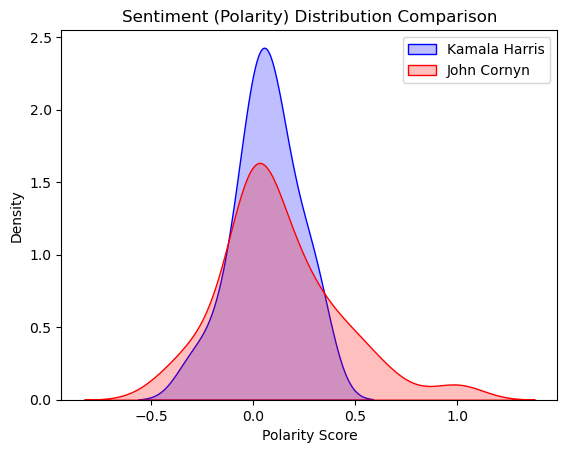

In [15]:
#filter tweets for two legislators
legislator_lib = congress_tweets[congress_tweets['screen_name']== 'SenKamalaHarris']
legislator_cons = congress_tweets[congress_tweets['screen_name']== 'JohnCornyn']

#visualize
sns.kdeplot(data=legislator_lib, x ='polarity', fill = True, label = "Kamala Harris", color = 'blue')
sns.kdeplot(data=legislator_cons, x ='polarity', fill = True, label = "John Cornyn", color = 'red')

plt.title('Sentiment (Polarity) Distribution Comparison')
plt.xlabel('Polarity Score')
plt.ylabel('Density')
plt.legend()
plt.show()


In [16]:
len(legislator_lib), len(legislator_cons)

(19, 63)

In [17]:
#legislator_lib.head() 
#legislator_cons.head()

In [18]:
#5 most negative
for tweet in legislator_lib.nsmallest(3, 'polarity')['text']:
    print('NEGATIVE: ', tweet + "\n")

#5 most positive
for tweet in legislator_lib.nlargest(3, 'polarity')['text']:
    print('POSITIVE: ', tweet + "\n")

NEGATIVE:  Racist attacks against Asian Americans and Asian immigrants are rising and it's sickening. No one should have to endure this, let alone doctors and nurses working tirelessly on the front lines to save lives.

We must speak out and condemn this. https://www.washingtonpost.com/business/2020/05/19/asian-american-discrimination/

NEGATIVE:  RT @BlkEconAlliance Monday at 6:30 pm EDT, BEA will host a videoconference with Senators @SenSchumer, @MarkWarner, @SenKamalaHarris, @CoryBooker, and @RepGregoryMeeks to discuss the importance of protecting Black businesses and jobs. Click here to RSVP: https://act.myngp.com/Forms/5558487851608247296 http://pbs.twimg.com/media/EdPysesUcAAHLdF.png

NEGATIVE:  Numbers don’t lie, and this administration is desperately trying to hide the size of its failure to address this pandemic. We've just surpassed 3.5 million confirmed COVID-19 cases. The American public deserves transparency. https://www.cnbc.com/2020/07/16/us-coronavirus-data-has-already-

In [19]:
#5 most negative
for tweet in legislator_cons.nsmallest(3, 'polarity')['text']:
    print('NEGATIVE: ', tweet + "\n")

#5 most positive
for tweet in legislator_cons.nlargest(3, 'polarity')['text']:
    print('POSITIVE: ', tweet + "\n")

NEGATIVE:  RT @Johnson4Dallas I spent some time today talking about violent crime and #COVID19 on WBAP’s Rick Roberts Show. Listen here: https://www.wbap.com/2020/11/24/rick-roberts-dallas-mayor-eric-johnson-says-its-in-your-hands/

NEGATIVE:  With my friend Karen Newton, President of Texas Federation of Republican Women - our party’s secret weapon http://pbs.twimg.com/media/EAa9lb8WwAAMswt.jpg

NEGATIVE:  RT @AriFleischer They can’t even say his name. https://twitter.com/jason_howerton/status/1276560108328235009 QT @jason_howerton .@SpeakerPelosi &amp; @chuckschumer, you are doing such an honorable job of honoring Floyd Taylor, I mean, George Taylor, um I mean, George Kirby...... http://pbs.twimg.com/ext_tw_video_thumb/1276559973414248454/pu/img/2U-s3aT6HIPOlO3i.jpg https://video.twimg.com/ext_tw_video/1276559973414248454/pu/vid/480x270/TstbOWoiMw3e1SMX.mp4?tag=10

POSITIVE:  RT @RetiredOrrin These are the Democrats best choices? http://pbs.twimg.com/media/ETMSFc4XkAEjT5y.jpg

POSITIV

In [20]:
#scatter words to sep the text frequency into classes
import scattertext as st

#measure of subjectivity
corpus = st.CorpusFromPandas(congress_tweets,
                             category_col= 'position',
                             text_col = 'tokens',
                             nlp = nlp).build()

# create html document
html = st.produce_scattertext_explorer(corpus,
                                       category= 'Sen',
                                       category_name = 'Sen',
                                       not_category_name = 'Rep',
                                       width_in_pixels = 1000,
                                       minimum_term_frequency = 5)
#write html to doc
open("Congress by Position (Polarity) Tweets.html", 'wb').write(html.encode('utf-8'))

/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


2386333

In [21]:
#measure of subjectivity
corpus = st.CorpusFromPandas(congress_tweets,
                             category_col= 'party',
                             text_col = 'tokens',
                             nlp = nlp).build()

# create html document
html = st.produce_scattertext_explorer(corpus,
                                       category= 'Republican',
                                       category_name = 'Republican',
                                       not_category_name = 'Democrat',
                                       width_in_pixels = 1000,
                                       minimum_term_frequency = 5)
#write html to doc
open("Congress by Party (Polarity) Tweets.html", 'wb').write(html.encode('utf-8'))

2386190

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [22]:
#congress_tweets.head()

In [23]:
# Engineered Features

#cleaning text, removing punctiationa and stop words
tokens = congress_tweets['tokens'].apply(rem_punc_stop)
#calc word count for each tweet [list]
congress_tweets['word_count'] = tokens.apply(len)
#tweet len
congress_tweets['tweet_len'] = congress_tweets['text'].apply(len)
#rejoining text from list output
congress_tweets['tokens'] = tokens.map(lambda text: ' '.join(text))

#subjectivity score
congress_tweets['subjectivity'] = congress_tweets['tokens'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


#df_1: word count + polarity score
wc_pol_df = congress_tweets[['tokens', 'tweet_len', 'word_count', 'polarity', 'subjectivity']]

wc_pol_df.head()

,tokens,tweet_len,word_count,polarity,subjectivity
908961,RepKClark 22 million Americans filed unemploym...,598,46,0.350000,0.800000
175615,Thanks came tonight forum GOPTaxLaw,204,5,0.200000,0.200000
64613,RepFilemonVela Dreamers TPS recipients essenti...,267,19,0.000000,0.300000
783091,HispanicCaucus JoaquinCastrotx TheBlackCaucus ...,377,34,0.000000,1.000000
553399,Thank NYGovCuomo today face extreme weather sy...,317,23,0.208333,0.583333


### Bag-of-words or Tf-idf

In [24]:
# Frequency Based featurization
X = congress_tweets['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop,
                            token_pattern = None)
tfidf_matrix = tf.fit_transform(X)

#convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names_out())
tfidf_df.head()

,\n,\n\n,\n\n\n,\n\n,\n\n,\n\n,\n,\n \n,\n,\n \n,...,🦗,🧒,🧗,🧘,🧡,🧪,🧵,🩸,🩺,󠁧󠁢󠁥󠁮󠁧󠁿
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [25]:
import os
print(os.getcwd())
#congress_tweets.head(3)

/Users/mariasmith/Desktop/Laptop/CSS273M/Projects/Computational Social Science Project 5


In [26]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 



In [27]:
# congress_tweets = congress_tweets.dropna(subset =['text'])
#position = congress_tweets[(congress_tweets['position'] == 'Rep')|(congress_tweets['position'] == 'Sen')]
#party = congress_tweets[(congress_tweets['party'] == 'Republican')| ((congress_tweets['party'] == 'Democrat')]
#congress_tweets = congress_tweets[:1000].reset_index(drop = True)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,word_count,polarity,tweet_len,subjectivity
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,...,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670",RepKClark 22 million Americans filed unemploym...,46,0.350000,598,0.800000
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,...,Democrat,"673,215","897,572","905,083","634,892",Thanks came tonight forum GOPTaxLaw,5,0.200000,204,0.200000
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",RepFilemonVela Dreamers TPS recipients essenti...,19,0.000000,267,0.300000
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,...,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",HispanicCaucus JoaquinCastrotx TheBlackCaucus ...,34,0.000000,377,1.000000
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,...,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Thank NYGovCuomo today face extreme weather sy...,23,0.208333,317,0.583333


In [28]:
congress_tweets['tokens'] = congress_tweets['text'].apply(lambda x: rem_punc_stop(x))

In [29]:
model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size=100, window=5,
                               min_count=5, sg=0, alpha=0.25, epochs=5, batch_words=10000)

In [30]:
words=list(model.wv.index_to_key)
print(words[:100])

['\n\n', 'I', '\n', 'The', 'QT', ' ', 'We', 'This', 'Trump', 'people', 'help', 'need', 'House', 'COVID19', 'President', 'today', 'health', 'Act', 'work', 'American', 'It', 'Congress', 'Americans', 'Today', 'time', '—', '“', '”', 'bill', 'US', 'support', 'country', 'families', 'care', 'Senate', 'communities', 'years', 'community', 'continue', 'nt', 'workers', 'new', 'day', 'protect', 'Thank', 'realDonaldTrump', 'federal', '️', 'working', '\n \n', 'public', 'week', 'like', 'America', 'In', 'year', 'right', 'Democrats', 'businesses', 'legislation', 'ensure', 'law', 'If', 'important', '–', 'My', 'crisis', 'coronavirus', 'funding', 'family', 'pandemic', 'As', 'vote', 'bipartisan', 'lives', 'proud', 'nation', 'relief', 'safe', 'state', 'fight', 'great', 'Our', 'passed', 'provide', 'know', 'women', 'access', 'million', 'office', 'children', 'A', 'pass', 'That', 'honor', 'students', 'small', 'stop', 'economy', 'He']


In [31]:
import numpy as np

# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key] #model.vocab
    #check if doc is not empty
    if not doc:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model.wv[doc], axis=0)

In [32]:
# embedding based featurization
embedded_word_list = []

for token in congress_tweets['tokens']:
    embedded_word_list.append(document_vector(model, token))

doc_avg_embeddings = pd.DataFrame(embedded_word_list)

In [33]:
doc_avg_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.119825,-0.024377,-0.316190,-0.424714,0.024914,-0.107144,-0.446469,0.407039,-0.485328,-0.215822,...,0.129026,0.195870,-0.239962,0.144022,0.046257,0.365818,0.240703,-0.505064,0.040769,-0.408974
1,-0.497490,-0.072963,-0.053082,-0.058392,-0.134546,-0.121598,-0.274462,0.148636,-0.123396,-0.076703,...,0.629538,-0.244997,-0.204871,0.076699,0.279799,0.208473,0.254929,0.357201,-0.407115,-0.151313
2,0.177421,0.116240,-0.544455,-0.063748,0.282049,-0.541535,0.161653,0.655024,-0.051351,-0.125078,...,0.417817,-0.184322,0.473220,0.287971,-0.071172,-0.029425,0.051595,0.376428,-0.189708,-0.154091
3,-0.183102,0.002185,-0.047045,-0.060925,0.219143,-0.306401,-0.310587,0.599801,-0.390795,-0.223002,...,0.342904,0.217472,0.106362,0.003969,-0.131731,0.180623,0.289052,-0.263700,0.008847,0.241244
4,-0.003507,0.271731,-0.082012,-0.286602,-0.277923,-0.187784,0.091370,0.806481,-0.439662,-0.402701,...,0.226323,0.059230,-0.182795,0.100460,-0.061440,-0.259475,-0.031670,-0.340088,-0.227326,-0.104241


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [34]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

#imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report



In [35]:
#predicting party using Logistic Regression and tokens

X = wc_pol_df.drop(columns=['tokens'])
y = congress_tweets['party'] #target variable

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create a model
model = LogisticRegression(max_iter=1000)

#fit/train the model
model.fit(X_train, y_train)
#predit on test set
y_pred = model.predict(X_test)

#evaluate: accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.67
              precision    recall  f1-score   support

    Democrat       0.67      1.00      0.80       669
 Independent       0.00      0.00      0.00         4
  Republican       0.00      0.00      0.00       327

    accuracy                           0.67      1000
   macro avg       0.22      0.33      0.27      1000
weighted avg       0.45      0.67      0.54      1000



/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

The test accurately identified Democrats but failed to recognize Republican tweets. I presume this is due to class imbalance or there being fewer Republicans to train and test on. In the future, I would stratify my sample and try this again.

In [36]:
#predicting party using Logistic Regression and polarity

X = wc_pol_df[['polarity']]
y = congress_tweets['position'] #target variable

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create a model
log_reg = LogisticRegression()

#fit/train the model
log_reg.fit(X_train, y_train)
#predit on test set
y_pred = log_reg.predict(X_test)

#evaluate: accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.76
              precision    recall  f1-score   support

         Rep       0.76      1.00      0.87       763
         Sen       0.00      0.00      0.00       237

    accuracy                           0.76      1000
   macro avg       0.38      0.50      0.43      1000
weighted avg       0.58      0.76      0.66      1000



/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [37]:
#Log Regression for predicting position on tfidf_df 

#predicting party using Logistic Regression and polarity

y_position = congress_tweets['position'] #target variable

#split data into training and testing sets
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(tfidf_df, y_position, test_size=0.2, random_state=42)

#create a model
log_reg_pos = LogisticRegression(max_iter=1000)

#fit/train the model
log_reg_pos.fit(X_train_pos, y_train_pos)

#predit on test set
y_pred_pos = log_reg_pos.predict(X_test_pos)

#evaluate: accuracy score
accuracy = accuracy_score(y_test_pos, y_pred_pos)
print(f'Accuracy:  {accuracy:.2f}')
print(classification_report(y_test_pos, y_pred_pos))

Accuracy:  0.77
              precision    recall  f1-score   support

         Rep       0.77      1.00      0.87       763
         Sen       0.75      0.04      0.07       237

    accuracy                           0.77      1000
   macro avg       0.76      0.52      0.47      1000
weighted avg       0.76      0.77      0.68      1000



The regression technique on the tf-idf data frame seems to have faired better than when I focused on tokens and polarity. Tf-idf seems to navigate noise a bit better. By focusing on nuance throughistribution, it seems to uncover a pattern not seeuncover a patternata frame.

In [38]:
# Random forest technique for predicting party on tfidf_df

from sklearn.ensemble import RandomForestClassifier

y_party = congress_tweets['party'] #target variable

#split data
X_train_party, X_test_party, y_train_party, y_test_party = train_test_split(tfidf_df, y_party, test_size=0.2, random_state=42)

#create and train the model
rf_party = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_party.fit(X_train_party, y_train_party)

#predict 
y_pred_party = rf_party.predict(X_test_party)

#evaluate
accuracy = accuracy_score(y_test_party, y_pred_party)
print(f'Accuracy:  {accuracy:.2f}')
print(classification_report(y_test_party, y_pred_party))



Accuracy:  0.72
              precision    recall  f1-score   support

    Democrat       0.73      0.95      0.82       669
 Independent       0.00      0.00      0.00         4
  Republican       0.72      0.28      0.40       327

    accuracy                           0.72      1000
   macro avg       0.48      0.41      0.41      1000
weighted avg       0.72      0.72      0.68      1000



/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

This model did better predicting Republicans than other models, but the recall is still low, meaning it's struggling to identify some or all of republican tweets. The standard model may require tuning to improve performance, but I think there is an imbalance--maybe other techniques like SMOTE for a more balanced dataset. 

In [39]:
# Random forest technique for predicting position on word2vec

from sklearn.ensemble import RandomForestClassifier

y_position = congress_tweets['position'] #target variable

#split data
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(doc_avg_embeddings, y_position, test_size=0.2, random_state=42)

#create and train the model
classifier_pos = RandomForestClassifier(n_estimators = 100, random_state = 42)
classifier_pos.fit(X_train_pos, y_train_pos)

#predict 
y_pred_pos = classifier_pos.predict(X_test_pos)

#evaluate
accuracy = accuracy_score(y_test_pos, y_pred_pos)
print(f'Accuracy:  {accuracy:.2f}')
print(classification_report(y_test_pos, y_pred_pos))

Accuracy:  0.76
              precision    recall  f1-score   support

         Rep       0.77      0.99      0.87       763
         Sen       0.56      0.02      0.04       237

    accuracy                           0.76      1000
   macro avg       0.66      0.51      0.45      1000
weighted avg       0.72      0.76      0.67      1000



Similar to the other models, this one is struggling with Sen due to a bias/imbalance. 

In [40]:
# Support Vector Machine Model (SVM) for predicting Party on word2vec df
# I wanted to try a new training/predicition technique

from sklearn.svm import SVC

y_party = congress_tweets['party'] #target

#split data
X_train_party, X_test_party, y_train_party, y_test_party = train_test_split(doc_avg_embeddings, y_party, test_size=0.2, random_state=42)

#create and train/fit
svm_party = SVC(kernel='rbf', C=1, gamma='auto', random_state=42)
svm_party.fit(X_train_party, y_train_party)

#predict
y_pred_party = svm_party.predict(X_test_party)

#evaluate
accuracy = accuracy_score(y_test_party, y_pred_party)
print(f'Accuracy:  {accuracy:.2f}')
print(classification_report(y_test_party, y_pred_party))

Accuracy:  0.67
              precision    recall  f1-score   support

    Democrat       0.67      1.00      0.80       669
 Independent       0.00      0.00      0.00         4
  Republican       1.00      0.01      0.01       327

    accuracy                           0.67      1000
   macro avg       0.56      0.34      0.27      1000
weighted avg       0.78      0.67      0.54      1000



/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Yes, at this point. It is abundantly clear we have oversampled Democrats. It's a data problem.

### Two Combined Models

In [41]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
# I will use ['state'] as the non-text feature to predict on party

from sklearn.preprocessing import OneHotEncoder

# one-hot code
encoder = OneHotEncoder(sparse=False)
state = encoder.fit_transform(congress_tweets[['state']])

# combine One-hot code with Tf-idf
combined_features = np.hstack((tfidf_df.values, state))

# target
y_target = congress_tweets['party']

# split
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(combined_features, y_target, test_size=0.2, random_state=42)

#train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_comb, y_train_comb)

#predict
y_pred_comb = model.predict(X_test_comb)

#evaluate
accuracy = accuracy_score(y_test_comb, y_pred_comb)
print(f'Accuracy:  {accuracy:.2f}')
print(classification_report(y_test_comb, y_pred_comb))


/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy:  0.83
              precision    recall  f1-score   support

    Democrat       0.85      0.92      0.88       669
 Independent       1.00      0.25      0.40         4
  Republican       0.81      0.66      0.73       327

    accuracy                           0.83      1000
   macro avg       0.88      0.61      0.67      1000
weighted avg       0.83      0.83      0.83      1000



In [42]:

# I will use ['state'] as the non-text feature to predict the position

# one-hot code
encoder = OneHotEncoder(sparse=False)
state = encoder.fit_transform(congress_tweets[['state']])

# combine One-hot code with Tf-idf
combined_features = np.hstack((tfidf_df.values, state))

# target
y_target = congress_tweets['position']

# split
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(combined_features, y_target, test_size=0.2, random_state=42)

#train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_comb, y_train_comb)

#predict
y_pred_comb = model.predict(X_test_comb)

#evaluate
accuracy = accuracy_score(y_test_comb, y_pred_comb)
print(f'Accuracy:  {accuracy:.2f}')
print(classification_report(y_test_comb, y_pred_comb))


/Users/mariasmith/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy:  0.80
              precision    recall  f1-score   support

         Rep       0.80      0.99      0.88       763
         Sen       0.82      0.21      0.33       237

    accuracy                           0.80      1000
   macro avg       0.81      0.60      0.61      1000
weighted avg       0.80      0.80      0.75      1000



The combination method was a much better method, compared to the featurized techniques above.

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Updated Response: I returned to my code after reviewing the instructions about removing platform-specific language. Doing so improved the classifications significantly. The models were even able to capture some "independent" data. 

When I implemented the standard preprocess with the removal of punctuation and stop words, I did not further customize it. However, I might further remove platform-specific language like RT to focus on more meaningful words. In addition, I might do more to translate emojis since they translate significant cultural meaning when faced with platform constraints (word count, flagged words, etc.). Further, my tweets and other social media posts often include misspellings; my dataset could have likely benefited from a spellchecker--however, I am not sure how well it would pick on certain culturally misspelled words over true typos. Specifying preprocessing to a particular corpus is important because it helps decipher noise and extract meaning.

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

Given my visualizations of sentiment, I gather that most tweets hovered around neutral tones. Occassionally, they inflected one way or the other but overall, my maintained neutral which is probably normal given that it is politics. 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

Validating exploratory and unsupervised learning approaches with supervisised learning algorithms (like Random Forest, Logistic Regression, and SVC) is important because it measures precision and accuracy which indicates effectiveness. It allows the coder to assess the quality of the features on prediction outcomes and it highlights areas for improvement (in my case biased/imbalanced data).

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

As evident in my project, combining text and non-text features together performed the best, despite the imbalanced data. Overall, the accuracy, precision, recall, and f1-scores improved when I included state information with features from Tf-idf.